# Characteristics of Businesses - Group Exercise

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

tech_variables = 'https://api.census.gov/data/2018/abstcb/variables.html'
owner_variables = 'https://api.census.gov/data/2018/abscbo/variables.html'
characteristics_variables = 'https://api.census.gov/data/2018/abscb/variables.html'
company_summary_variables = 'https://api.census.gov/data/2018/abscs/variables.html'


### Get Tables of Variables

In [2]:
tech_vars = pd.read_html(tech_variables)[0]
owner_vars = pd.read_html(owner_variables)[0]
characteristic_vars = pd.read_html(characteristics_variables)[0]
company_summary_vars = pd.read_html(company_summary_variables)[0]

tech_vars = tech_vars[[_ for _ in tech_vars.columns[:2]]]
owner_vars = owner_vars[[_ for _ in owner_vars.columns[:2]]]
characteristic_vars = characteristic_vars[[_ for _ in characteristic_vars.columns[:2]]]
company_summary_vars = company_summary_vars[[_ for _ in company_summary_vars.columns[:2]]] 

tech_vars.rename(columns = {'Label': 'Tech Labels'}, inplace = True)
owner_vars.rename(columns = {'Label': 'Owner Labels'}, inplace = True)
characteristic_vars.rename(columns = {'Label': 'Characteristic Labels'}, inplace = True)
company_summary_vars.rename(columns = {'Label': 'Company Summary Labels'}, inplace = True)

In [3]:
grouped_tables = pd.merge(tech_vars, owner_vars, left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables = pd.merge(grouped_tables, characteristic_vars, left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables = pd.merge(grouped_tables, company_summary_vars , left_on = 'Name', right_on = 'Name', how = 'outer')
grouped_tables.fillna("-", inplace = True)
grouped_tables = grouped_tables[(~grouped_tables['Tech Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Owner Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Characteristic Labels'].str.contains('Standard error|standard error'))]
grouped_tables = grouped_tables[(~grouped_tables['Company Summary Labels'].str.contains('Standard error|standard error'))]

grouped_tables.reset_index(drop = True, inplace = True)
grouped_tables = grouped_tables[:-2]

In [4]:
# grouped_tables.sort_values(by = 'Name', ascending = False)
vars_of_interest = [
    'NAICS2017',
    'YIBSZFI',
    'SEX',
    'QDESC',
    'NSFSZFI',
    'GEO_ID',
    'RACE_GROUP',
    'BUSCHAR',
    'OWNER_RACE',
    'OWNER_SEX']
target_subset = grouped_tables[(grouped_tables['Name'].isin(vars_of_interest))]
target_subset = target_subset[['Name','Company Summary Labels','Characteristic Labels','Owner Labels','Tech Labels']]

### Build variable strings to pass to api call


In [5]:
variable_dict = {}
for i,label in enumerate(target_subset.columns[1:]):
    variable_list = []
    for item in target_subset[(target_subset[label] != "-")].Name.tolist():
        variable_list.append(item)
        variable_list.append(f'{item}_LABEL')
    variable_list = [_ for _ in variable_list if _ not in ['GEO_ID_LABEL']]#, 'QDESC_LABEL']]
    in_table = "NAME," + ",".join(variable_list)
    variable_dict[i] = in_table

In [6]:
industry_code = '61'
qdesc1 = 'B27'
links = [
    f'https://api.census.gov/data/2018/abscs?get={variable_dict[0]},FIRMPDEMP&for=us:*', #I CHANGED THIS from for=state:*
    f'https://api.census.gov/data/2018/abscb?get={variable_dict[1]},FIRMPDEMP&for=state:*',
    f'https://api.census.gov/data/2018/abscbo?get={variable_dict[2]},OWNCHAR,OWNCHAR_LABEL&for=us:*&for=QDESC_LABEL=YRACQBUS',
    f'https://api.census.gov/data/2018/abstcb?get={variable_dict[3]},FIRMPDEMP,TECHUSE&for=state:*',
]

def get_data_frame(url):
    return pd.read_csv(url)
    
for link in links:
    print(link)
    print("")

https://api.census.gov/data/2018/abscs?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,YIBSZFI,YIBSZFI_LABEL,FIRMPDEMP&for=us:*

https://api.census.gov/data/2018/abscb?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,QDESC,QDESC_LABEL,BUSCHAR,BUSCHAR_LABEL,YIBSZFI,YIBSZFI_LABEL,FIRMPDEMP&for=state:*

https://api.census.gov/data/2018/abscbo?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNER_SEX,OWNER_SEX_LABEL,QDESC,QDESC_LABEL,OWNCHAR,OWNCHAR_LABEL&for=us:*&for=QDESC_LABEL=YRACQBUS

https://api.census.gov/data/2018/abstcb?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,NSFSZFI,NSFSZFI_LABEL,RACE_GROUP,RACE_GROUP_LABEL,SEX,SEX_LABEL,FIRMPDEMP,TECHUSE&for=state:*



### The cell below is where the dataframes are first stored.

In [7]:
comp_sum_df = get_data_frame(links[0]) # Company Summary
bus_char_df = business_char_df = get_data_frame(links[1]) # Business Characteristics
bus_own_df = business_own_df = get_data_frame(links[2]) # Business Owners
bus_tech_df = get_data_frame(links[3]) # Business Tech   

In [8]:
df_collection = [comp_sum_df, bus_char_df, bus_own_df, bus_tech_df]    
df_names = ['comp_sum_df', 'bus_char_df', 'bus_own_df', 'bus_tech_df']   

### Clean DataFrames

In [9]:
drop_list = [
    'race_group','sex','yibszfi','qdesc','buschar',
    'owner_race','owner_sex','us','ownchar'
]

for df in df_collection:
    column_names = [_ for _ in df.columns.tolist()]
    new_column_names = [_.replace("[[","").replace('"',"").replace("]","").lower() for _ in column_names]

    df.columns = new_column_names
    df.drop(columns = [_ for _ in new_column_names if ('unnamed' in _ or _ in drop_list)],inplace = True)
    df['name'] = df['name'].apply(lambda x: x.replace("[","").replace('"',""))
    
    if 'sex_label' in df.columns:
        df.rename(columns = {'sex_label': 'gender'}, inplace = True)
    
    if 'owner_sex_label' in df.columns:
        df.rename(columns = {'owner_sex_label': 'gender'}, inplace = True)
    
    if 'naics2017_label' in df.columns:
        df.rename(columns = {'naics2017_label': 'industry'}, inplace = True)
        
    if 'naics2017' in df.columns:
        df.rename(columns = {'naics2017': 'industry_code'}, inplace = True)

### Display some info about dataframes.

In [10]:
for i,df in enumerate(df_collection):
    print('\n############# NEW DATAFRAME ################')
    print('Displaying column value counts where there are fewer than 10 unique values in the column.')
    print(f'\n---  DataFrame: {df_names[i]} ---------------------')
    print(f'Columns: {", ".join(df.columns.tolist())}')
    for column in df:
        if len(df[column].unique().tolist()) < 10:
            print(df[column].value_counts())
            print("")
    print('############# END OF DATAFRAME INFO ################\n')


############# NEW DATAFRAME ################
Displaying column value counts where there are fewer than 10 unique values in the column.

---  DataFrame: comp_sum_df ---------------------
Columns: name, geo_id, industry_code, industry, race_group_label, gender, yibszfi_label, firmpdemp
United States    4823
Name: name, dtype: int64

0100000US    4823
Name: geo_id, dtype: int64

Total                                         588
White                                         588
Nonminority                                   588
Minority                                      581
Asian                                         551
Black or African American                     528
Equally minority/nonminority                  520
American Indian and Alaska Native             487
Native Hawaiian and Other Pacific Islander    392
Name: race_group_label, dtype: int64

Total                  1286
Male                   1263
Female                 1179
Equally male/female    1095
Name: gender, dtype:

In [11]:
comp_sum_df[['industry_code','industry']].drop_duplicates();

In [12]:
gender_by_state_cs = comp_sum_df[
    (comp_sum_df['industry_code'].isin(['54','52']))
    ].groupby(by = ['name','industry','gender']
             )[['gender']].agg('count').rename(columns = {'gender': 'gender_count'}).reset_index()

gender_by_state_cs.sort_values(by = ['name', 'industry', 'gender'], inplace = True)
gs = gender_by_state_cs


In [13]:
print(len(comp_sum_df.name.unique())/3)

0.3333333333333333


In [14]:
workingDF = df_collection[0]
workingDF = workingDF[workingDF['firmpdemp'] != 0]
workingDF = workingDF[workingDF['yibszfi_label'] == 'All firms']
workingDF = workingDF[workingDF['race_group_label'] == 'Total']

workingDF = workingDF[workingDF['industry'] != 'Industries not classified']

In [15]:
workingDF.drop(['geo_id', 'name', 'industry_code', 'race_group_label', 'yibszfi_label'], axis = 1, inplace = True)

In [19]:
workingDF = workingDF[workingDF['gender'] != 'Total']
workingDF = workingDF[workingDF['industry'] != 'Total for all sectors']

workingDF = workingDF.sort_values(by = 'firmpdemp', ascending = False)

In [20]:

#workingDF.plot.bar(x = 'industry', y = 'firmpdemp', figsize = (15,15))


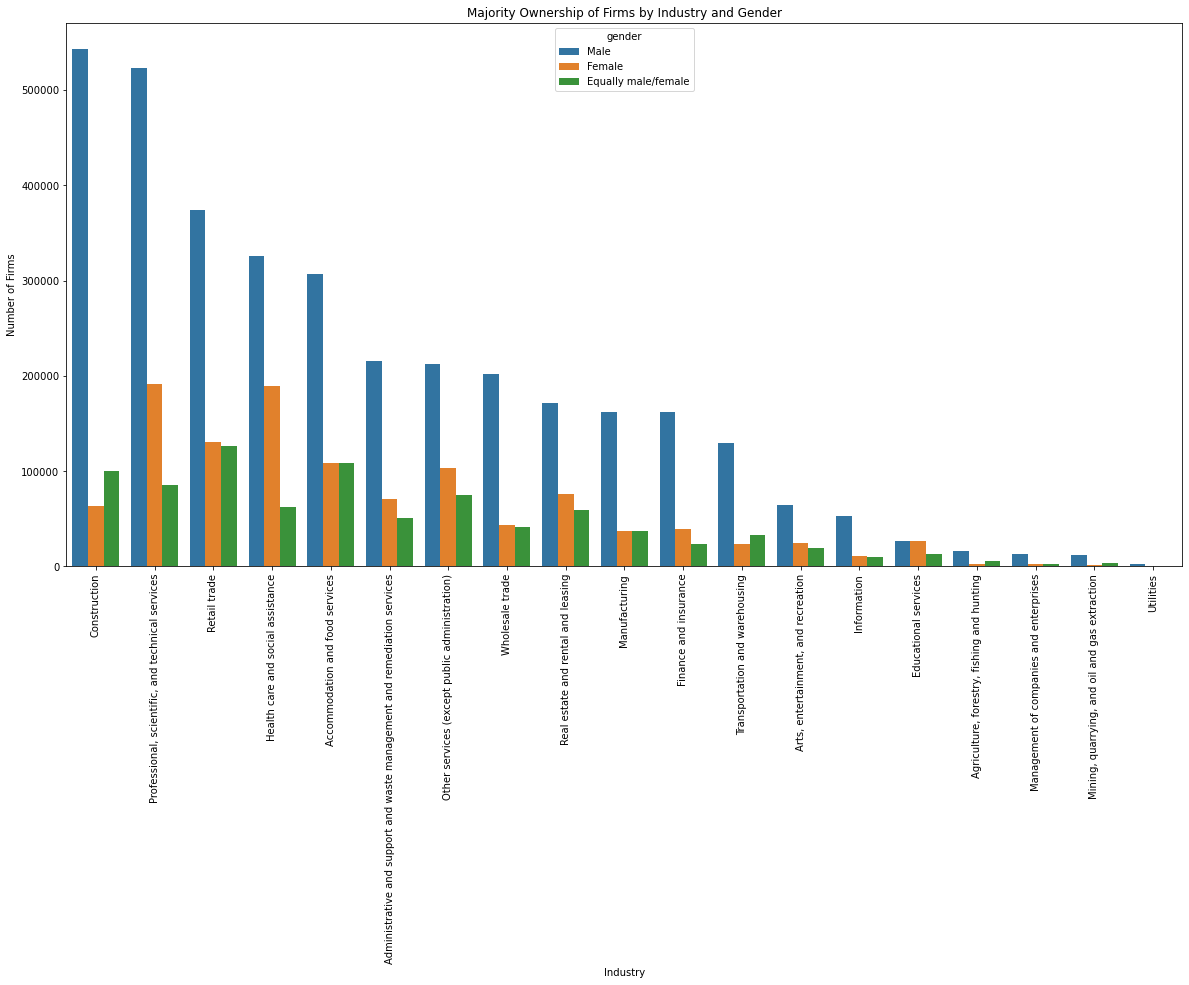

In [27]:
plt.figure(figsize=(20, 10))

ax = sns.barplot(data = workingDF, x = 'industry', y = 'firmpdemp', hue = 'gender')
ax.set(xlabel ="Industry", ylabel = "Number of Firms", title ='Majority Ownership of US Firms by Industry and Gender')
plt.xticks(rotation = 90);
#Education Services has the highest female ownership:male ownership ratio, followed by health care and social services
#The most male-dominated industry tracked is construction